Data Population

In [1]:
# import os
# from PIL import Image
# import re

# # Define paths
# dataset_path = "./Dataset"
# categories = ["akbar", "faisalabad", "galaxy", "Saher"]
# output_dir = dataset_path

# # Augmentation functions
# def rotate_image(image, angle):
#     return image.rotate(angle, expand=True)

# def flip_image(image, direction):
#     if direction == "horizontal":
#         return image.transpose(Image.FLIP_LEFT_RIGHT)
#     elif direction == "vertical":
#         return image.transpose(Image.FLIP_TOP_BOTTOM)
#     return image

# # Function to get the next image number
# def get_next_image_number(folder_path, category):
#     existing_files = os.listdir(folder_path)
#     max_num = 0
#     pattern = re.compile(rf"{category}-01 \((?P<num>\d+)\)\.jpg")
#     for fname in existing_files:
#         match = pattern.match(fname)
#         if match:
#             num = int(match.group("num"))
#             max_num = max(max_num, num)
#     return max_num + 1

# # Process each category
# for category in categories:
#     folder_path = os.path.join(dataset_path, category)
#     if not os.path.exists(folder_path):
#         print(f"Folder {folder_path} does not exist")
#         continue

#     # Get list of images
#     image_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
    
#     # Get starting number for new images
#     next_image_num = get_next_image_number(folder_path, category)
    
#     for img_file in image_files:
#         img_path = os.path.join(folder_path, img_file)
#         try:
#             with Image.open(img_path) as img:
#                 # Define augmentations
#                 augmentations = [
#                     ("rotate_90", lambda x: rotate_image(x, 90)),
#                     ("rotate_180", lambda x: rotate_image(x, 180)),
#                     ("rotate_270", lambda x: rotate_image(x, 270)),
#                     ("flip_horizontal", lambda x: flip_image(x, "horizontal")),
#                     ("flip_vertical", lambda x: flip_image(x, "vertical"))
#                 ]
                
#                 # Apply each augmentation
#                 for aug_name, aug_func in augmentations:
#                     aug_img = aug_func(img)
#                     output_filename = f"{category}-01 ({next_image_num}).jpg"
#                     output_path = os.path.join(folder_path, output_filename)
#                     aug_img.save(output_path, quality=95)
#                     print(f"Saved {output_path}")
#                     next_image_num += 1
                    
#         except Exception as e:
#             print(f"Error processing {img_path}: {e}")

# print("Dataset augmentation complete!")

Pre Processing & Feature Extraction

In [ ]:
import cv2
import numpy as np
from skimage import measure, feature
import os
import glob
import pandas as pd
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed
from skimage.morphology import label

# Feature Extraction Function


def extract_features(image_path):
    try:
        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")
            return [0] * 8  # Return zeros for all 8 features
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Preprocessing: Denoise and threshold
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        _, thresh = cv2.threshold(
            blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Feature 1: Spike Length
        contours, _ = cv2.findContours(
            thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            spike_length = max(w, h)
        else:
            spike_length = 0

        # Feature 2: Number of Grains (using watershed segmentation)
        markers = np.zeros_like(gray)
        markers[gray < threshold_otsu(gray)] = 1
        markers[gray > threshold_otsu(gray)] = 2
        labels_ws = watershed(-gray, markers, mask=thresh)
        num_grains = len(np.unique(labels_ws)) - 1

        # Feature 3: Awn Length and Feature 4: Awn Density
        edges = cv2.Canny(gray, 100, 200)
        awns = np.sum(edges > 0)  # Awn density
        contours_awn, _ = cv2.findContours(
            edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        awn_length = max([cv2.arcLength(c, False)
                         for c in contours_awn], default=0)

        # Feature 5: Color Intensity (mean hue)
        hue = hsv[:, :, 0]
        mean_hue = np.mean(hue[hue > 0]) if np.any(hue > 0) else 0

        # Feature 6: Grain Size Distribution (mean area)
        grain_areas = []
        for region in measure.regionprops(label(labels_ws)):
            grain_areas.append(region.area)
        grain_size_mean = np.mean(grain_areas) if grain_areas else 0

        # Feature 7: Texture Analysis (GLCM contrast)
        glcm = feature.graycomatrix(
            gray, [5], [0], levels=256, normed=True, symmetric=True)
        texture_contrast = feature.graycoprops(glcm, 'contrast')[0, 0]

        # Feature 8: Grain Density per Unit Length
        grain_density = num_grains / spike_length if spike_length > 0 else 0

        return [spike_length, num_grains, awn_length, awns, mean_hue, grain_size_mean, texture_contrast, grain_density]
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return [0] * 8  # Return zeros for all 8 features

# Process Dataset and Save Features


def process_dataset(dataset_dir, output_file):
    features = []
    labels = []
    categories = ['akbar', 'faisalabad', 'galaxy', 'Saher']

    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        image_paths = glob.glob(os.path.join(
            category_path, f"{category}-01*.jpg"))

        if not image_paths:
            print(f"No images found in {category_path}")
        else:
            for image_path in image_paths:
                feat = extract_features(image_path)
                features.append(feat)
                labels.append(categories.index(category))
                print(f"Processed: {image_path}")

    # Save features and labels to CSV
    df = pd.DataFrame(features, columns=['spike_length', 'num_grains', 'awn_length', 'awn_density', 'mean_hue',
                                         'grain_size_mean', 'texture_contrast', 'grain_density'])
    df['label'] = labels
    df.to_csv(output_file, index=False)
    print(f"Features saved to {output_file}")


# Main Execution
if __name__ == "__main__":
    dataset_dir = "Dataset"
    output_file = "features.csv"
    process_dataset(dataset_dir, output_file)

Processed: Dataset\akbar\akbar-01 (1).jpg
Processed: Dataset\akbar\akbar-01 (10).jpg
Processed: Dataset\akbar\akbar-01 (100).jpg
Processed: Dataset\akbar\akbar-01 (101).jpg
Processed: Dataset\akbar\akbar-01 (102).jpg
Processed: Dataset\akbar\akbar-01 (103).jpg
Processed: Dataset\akbar\akbar-01 (104).jpg
Processed: Dataset\akbar\akbar-01 (105).jpg
Processed: Dataset\akbar\akbar-01 (106).jpg
Processed: Dataset\akbar\akbar-01 (107).jpg
Processed: Dataset\akbar\akbar-01 (108).jpg
Processed: Dataset\akbar\akbar-01 (109).jpg
Processed: Dataset\akbar\akbar-01 (11).jpg
Processed: Dataset\akbar\akbar-01 (110).jpg
Processed: Dataset\akbar\akbar-01 (111).jpg
Processed: Dataset\akbar\akbar-01 (112).jpg
Processed: Dataset\akbar\akbar-01 (113).jpg
Processed: Dataset\akbar\akbar-01 (114).jpg
Processed: Dataset\akbar\akbar-01 (115).jpg
Processed: Dataset\akbar\akbar-01 (116).jpg
Processed: Dataset\akbar\akbar-01 (117).jpg
Processed: Dataset\akbar\akbar-01 (118).jpg
Processed: Dataset\akbar\akbar-01 (1

Model Training & Testing

Model Accuracy: 99.07%
F1 Score: 0.99
Confusion Matrix:
[[171   0   0   0]
 [  1 130   0   0]
 [  5   0 140   0]
 [  0   0   0 197]]


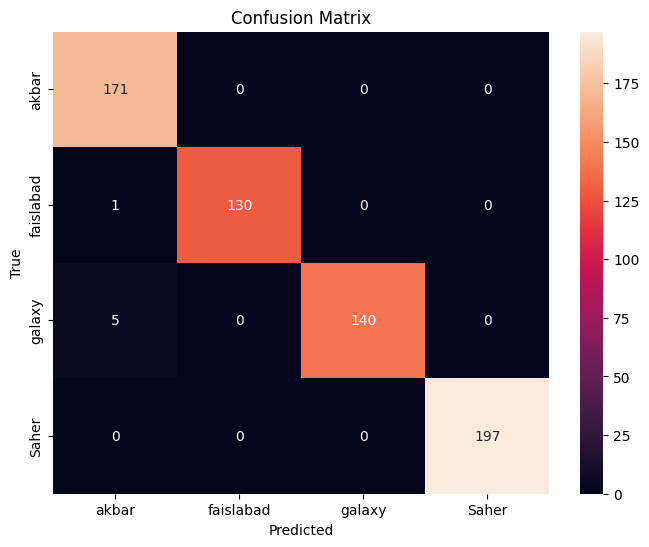

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # Import joblib at the top

# Load Features


def load_features(features_file):
    df = pd.read_csv(features_file)
    if df.empty:
        raise ValueError(
            f"No data found in {features_file}. Check the feature extraction step.")

    X = df.drop('label', axis=1).values
    y = df['label'].values
    return X, y

# Train and Evaluate Model


def train_and_evaluate(X, y):
    categories = ['akbar', 'faislabad', 'galaxy', 'Saher']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Train Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    # Save the trained model here
    joblib.dump(model, 'wheat_classifier_model.joblib')

    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print metrics
    print(f"Model Accuracy: {accuracy * 100:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d',
                xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


# Main Execution
if __name__ == "__main__":
    features_file = "features.csv"
    try:
        X, y = load_features(features_file)
        train_and_evaluate(X, y)
    except ValueError as e:
        print(f"Error: {e}")